In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.pyplot import style
import mmcv
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)

    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data):
        C = torch.tensor([[3], [10], [15],[27]], dtype = float, device = device)
        S = torch.tensor([[0.2669],[0.9528],[0.4450],[0.6691]], device='cuda:0', dtype=torch.float64)
        W = torch.tensor([[30.123, 45.1631, 27.672, 53.124]], device='cuda:0',dtype=torch.float64)
        r = (-1 * (input_data-C) / torch.pow(S,2)) * (torch.exp(-1 * (torch.pow((input_data - C), 2) / (2 * torch.pow(S, 2)))))
        ori_grad = torch.mm(W, r)
        return ori_grad
    
    def target_grad(self, input_data, centers, sigmas, weights):
        C = torch.tensor([[3], [10], [15],[27]], dtype = float, device = device)
        S = torch.tensor([[0.2669],[0.9528],[0.4450],[0.6691]], device='cuda:0', dtype=torch.float64)
        W = torch.tensor([[30.123, 45.1631, 27.672, 53.124]], device='cuda:0',dtype=torch.float64)
        r = (-1 * (input_data-C) / torch.pow(S,2)) * (torch.exp(-1 * (torch.pow((input_data - C), 2) / (2 * torch.pow(S, 2)))))
        ori_grad = torch.mm(W, r)
        true_grad = ori_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        L2_2_error = -2 * (target_grad - pred_grad)
        
        len_ = len(L2_2_error)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)
        
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                target_grad = self.first_grad(input_data)
                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(20, 10))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights)
            else:
                na = 0

C:\Users\chanyoung\anaconda3\envs\cooling\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


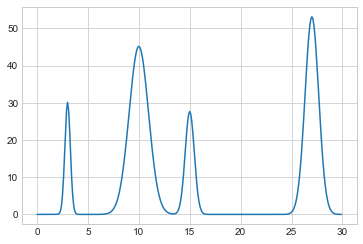

In [2]:
C = torch.tensor([[3], [10], [15],[27]], dtype = float, device = device)
S = torch.tensor([[0.2669],[0.9528],[0.4450],[0.6691]], device='cuda:0', dtype=torch.float64)
W = torch.tensor([[30.123, 45.1631, 27.672, 53.124]], device='cuda:0',dtype=torch.float64)

def data_gen(input_):
    output =torch.exp(-1 * (torch.pow(input_ - C, 2) / \
                                (2 * torch.pow(S, 2))))
    return output # size = (num_rbf, 1)

def data_gradient(x, center_list, sigma_list, weight_list):
    rbf_output = (-1 * (x-center_list) / torch.pow(sigma_list,2)) * (torch.exp(-1 * (torch.pow((x - center_list), 2) / (2 * torch.pow(sigma_list, 2)))))
    rbf_grad = torch.mm(weight_list, rbf_output)
    
    return rbf_grad

def rbf_gradient(x, center_list, sigma_list, weight_list):
    rbf_output = (-2 * (x-center_list) / torch.pow(sigma_list,2)) * (torch.exp(-1 * (torch.pow((x - center_list), 2) / (torch.pow(sigma_list, 2)))))
    rbf_grad = torch.mm(weight_list, rbf_output)
    
    return rbf_grad

input_ = torch.tensor([i/10 for i in range(300)], dtype = float, device = device)
target2 = torch.mm(W, data_gen(input_))
gr = rbf_gradient(input_, C, S, W)
plt.plot(input_.cpu().detach().numpy(), target2[0].cpu().detach().numpy())

0
0 epoch MSE Loss: 128379.33661544259
249 epoch MSE Loss: 12638.73809196273
499 epoch MSE Loss: 957.8846997784673
749 epoch MSE Loss: 505.1620964354033
999 epoch MSE Loss: 477.0372971638075
1249 epoch MSE Loss: 464.40849473708926
1499 epoch MSE Loss: 453.8670849927944
1749 epoch MSE Loss: 444.5075791126223
1999 epoch MSE Loss: 436.2113512483368
2249 epoch MSE Loss: 428.8129182945562
2499 epoch MSE Loss: 422.14476005284524
2749 epoch MSE Loss: 416.05816620542805
2999 epoch MSE Loss: 410.4230149148216
3249 epoch MSE Loss: 405.128326400325
3499 epoch MSE Loss: 400.08501564562596
3749 epoch MSE Loss: 395.2293567804634
3999 epoch MSE Loss: 390.5255968323126
4249 epoch MSE Loss: 385.9641863922378
4499 epoch MSE Loss: 381.5532342302359
4749 epoch MSE Loss: 377.3048589980158
4999 epoch MSE Loss: 373.2264552313288
train_loss tensor(373.2109, device='cuda:0', dtype=torch.float64)
best loss :  tensor(373.2265, device='cuda:0', dtype=torch.float64)


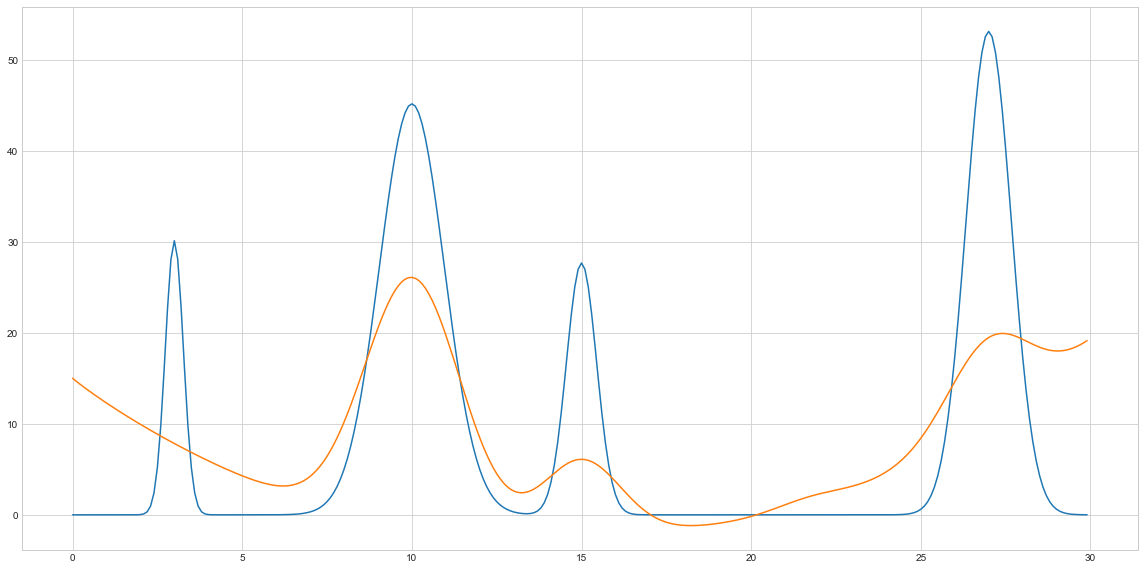

1
tensor(91142.0413, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 35.821934025990515
1999 epoch MSE Loss: 27.180133471770834
2999 epoch MSE Loss: 22.998309372892432
3999 epoch MSE Loss: 19.760236641480617
4999 epoch MSE Loss: 17.432802201940735
train_loss tensor(17.4309, device='cuda:0', dtype=torch.float64)
best loss :  tensor(17.4328, device='cuda:0', dtype=torch.float64)


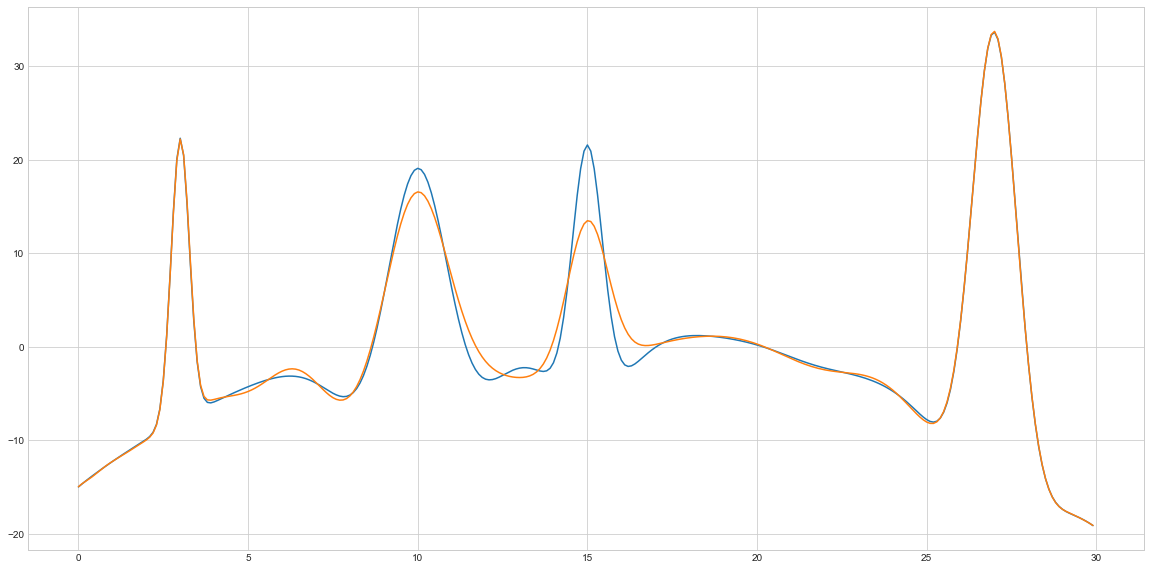

2
tensor(175.2495, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 7.563326942142109
1999 epoch MSE Loss: 4.15024416175803
2999 epoch MSE Loss: 2.8603909337186315
3999 epoch MSE Loss: 2.1681917081919964
4999 epoch MSE Loss: 1.745209894505042
train_loss tensor(1.7449, device='cuda:0', dtype=torch.float64)
best loss :  tensor(1.7452, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-06
----------------------------------------------


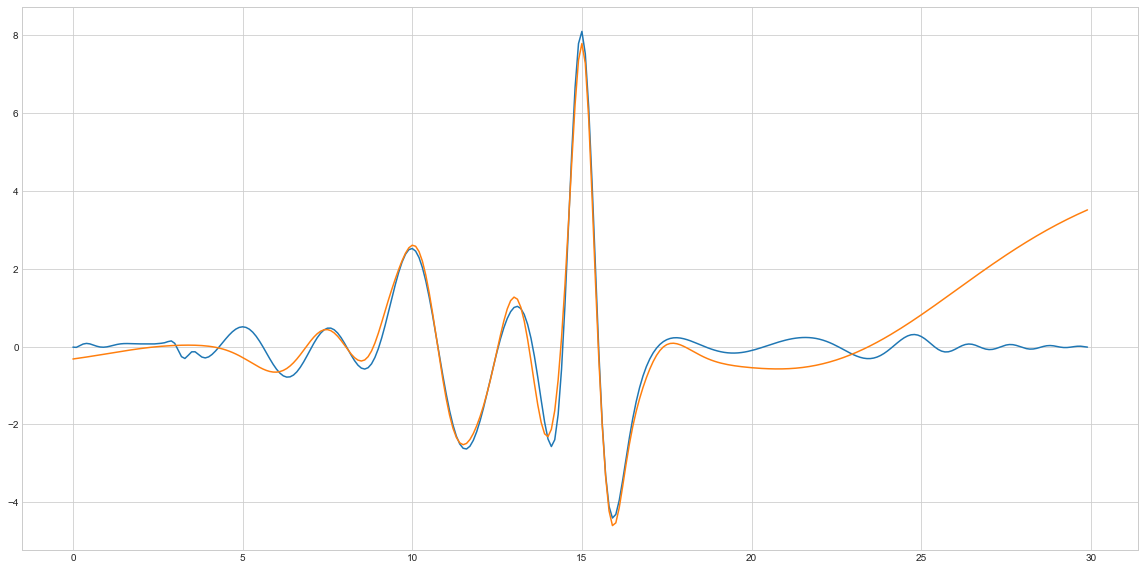

3
tensor(961.3548, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.7021878106608254
1999 epoch MSE Loss: 0.6660157034088229
2999 epoch MSE Loss: 0.6549466233743021
3999 epoch MSE Loss: 0.6494536524496666
4999 epoch MSE Loss: 0.645881075552487
train_loss tensor(0.6459, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.6459, device='cuda:0', dtype=torch.float64)


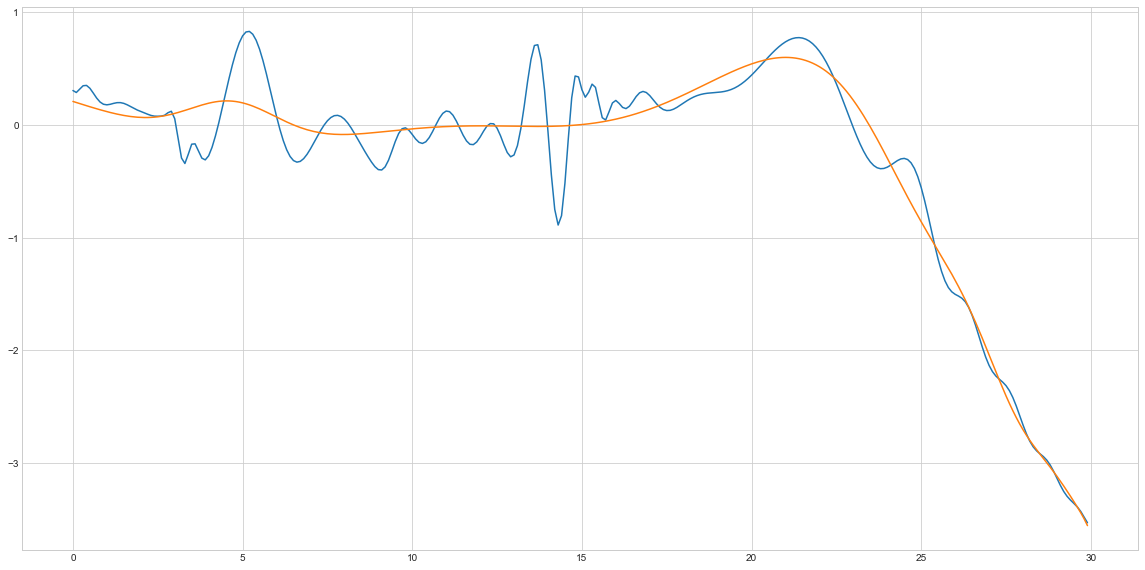

4
tensor(1.3339, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.4198967551070241
1999 epoch MSE Loss: 0.25537757940268047
2999 epoch MSE Loss: 0.19646159310013597
3999 epoch MSE Loss: 0.16253100545059804
4999 epoch MSE Loss: 0.15288713390018188
train_loss tensor(0.1529, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.1529, device='cuda:0', dtype=torch.float64)
change round number 6
----------------------------------------------


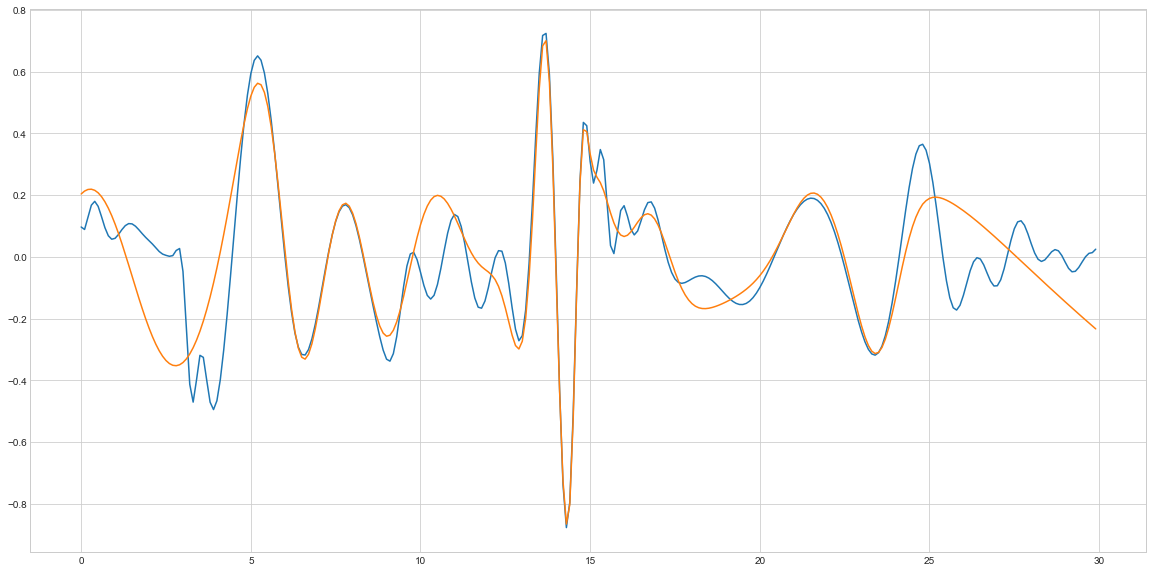

5
tensor(2.1524, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.10683606825555086
1999 epoch MSE Loss: 0.09833208155780995
2999 epoch MSE Loss: 0.0958723225775085
3999 epoch MSE Loss: 0.09441511471738721
4999 epoch MSE Loss: 0.09339960798039455
train_loss tensor(0.0934, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0934, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-05
----------------------------------------------


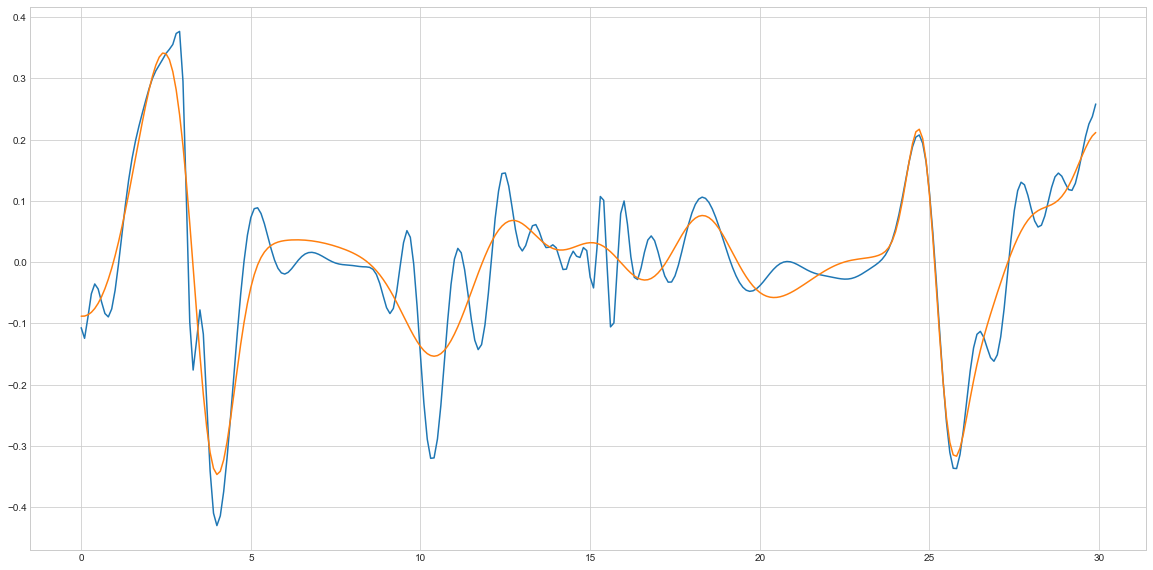

6
tensor(0.2008, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.009538604792722541
1999 epoch MSE Loss: 0.00744258339483569
2999 epoch MSE Loss: 0.006321432277524282
3999 epoch MSE Loss: 0.005760859159525376
4999 epoch MSE Loss: 0.005497157010293099
train_loss tensor(0.0055, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0055, device='cuda:0', dtype=torch.float64)


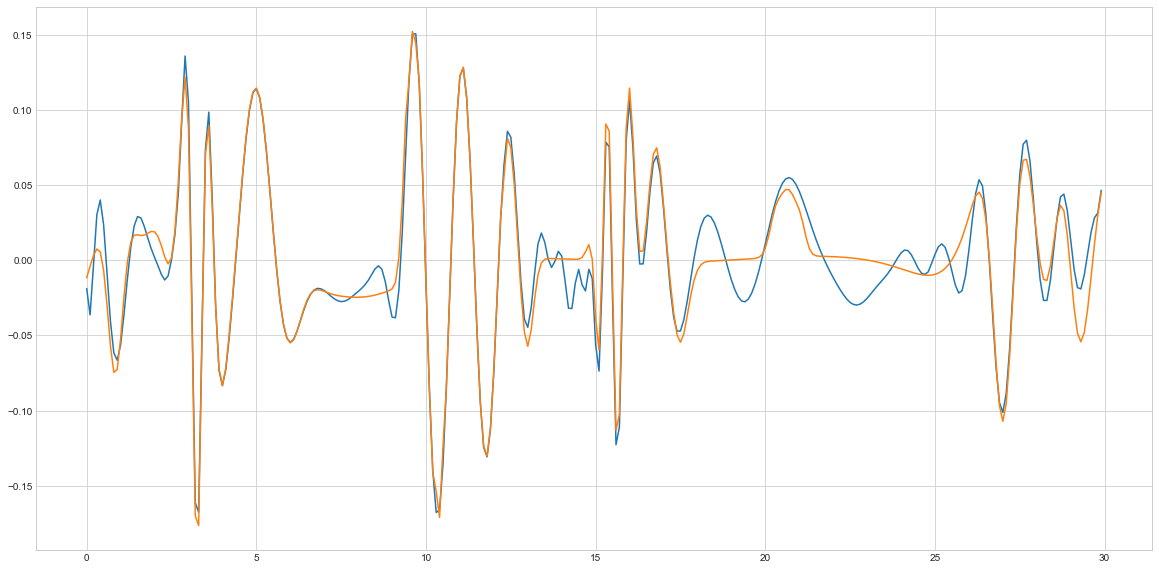

7
tensor(0.0057, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.0024842689077973676
1999 epoch MSE Loss: 0.0023586263460119183
2999 epoch MSE Loss: 0.002405128580630205
3999 epoch MSE Loss: 0.002588338583885244
4999 epoch MSE Loss: 0.0025994959313187945
train_loss tensor(0.0022, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0022, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------


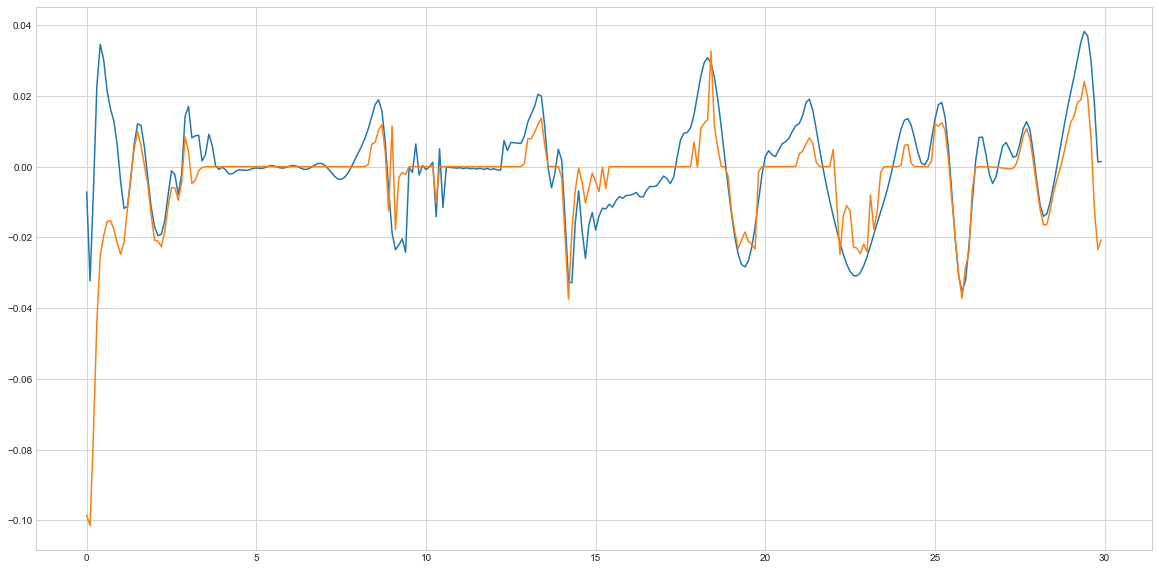

8
tensor(0.0031, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.0009509018834232401
1999 epoch MSE Loss: 0.0009478347705196785
2999 epoch MSE Loss: 0.0009465139550857793
3999 epoch MSE Loss: 0.0009457434430344986
4999 epoch MSE Loss: 0.0009451277336792722
train_loss tensor(0.0008, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0008, device='cuda:0', dtype=torch.float64)


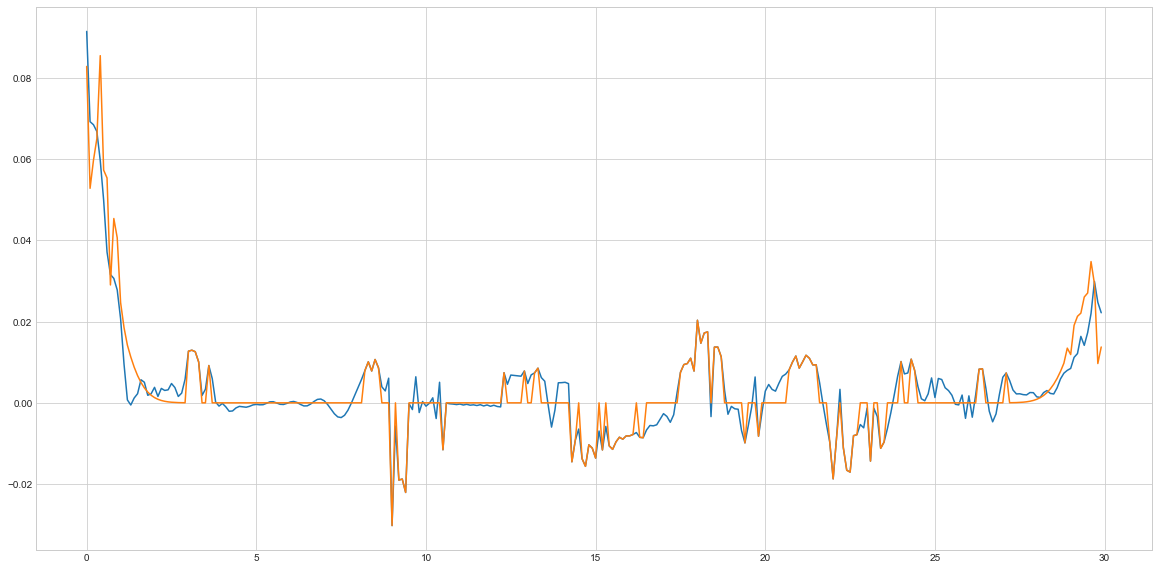

93.78676 sec


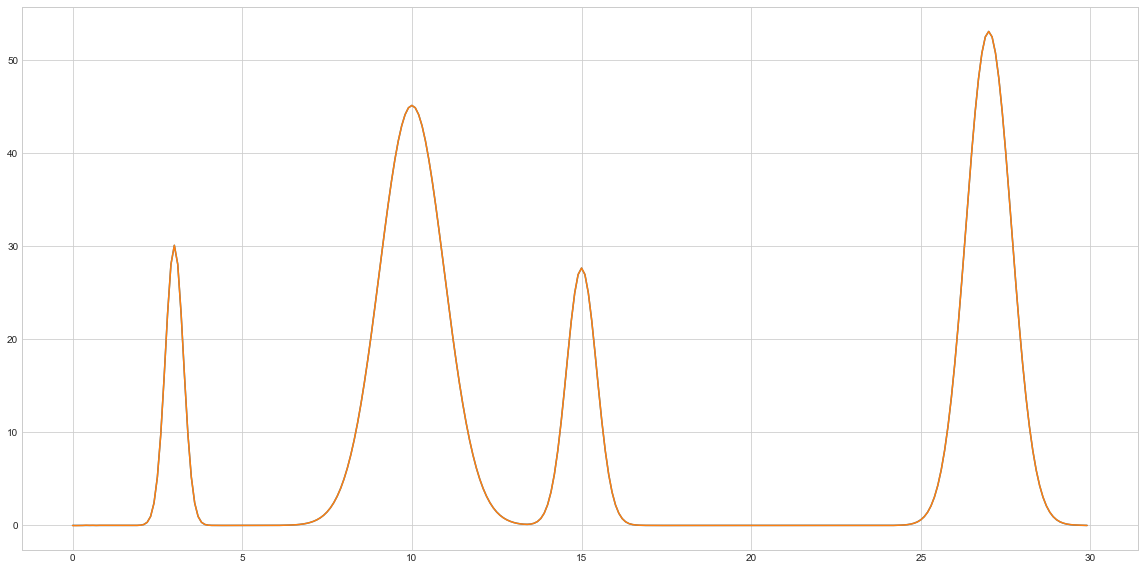

In [3]:
start = time.time()
model2 = RBF_Add(100, device)
model2.train(input_, target2, 5000, 1e-06, 0.001, 5)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_.cpu().detach().numpy(), target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model2.pred(input_)[1][0].cpu().detach().numpy())
rbf_grad2 = rbf_gradient(input_, model2.done_radial_layer_centers, model2.done_radial_sigma, model2.done_linear_layer_weights)

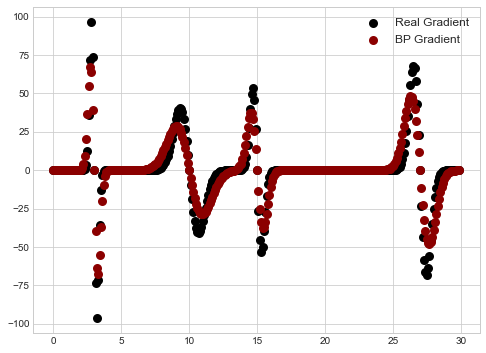

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(input_.cpu().detach().numpy(), gr.cpu().detach().numpy(),label='Real Gradient', linewidths = 3.0, color = 'black',zorder=2)
plt.scatter(input_.cpu().detach().numpy(), rbf_grad2[0].cpu().detach().numpy(),label='BP Gradient', linewidths = 3.0, color = 'darkred',zorder=2)
plt.legend(fontsize = 12,facecolor='gray',edgecolor='black',fancybox=True)
plt.show()

In [5]:
print('BP fitting loss:',torch.mean(torch.abs(target2 - model2.pred(input_)[1])))
print('BP gradient loss:',torch.mean(torch.abs(gr - rbf_grad2[0])))

BP fitting loss: tensor(0.0026, device='cuda:0', dtype=torch.float64)
BP gradient loss: tensor(5.1458, device='cuda:0', dtype=torch.float64)
